In [18]:
from skimage.transform import resize
from PIL import Image
from ipywidgets import interact, Select
from myLabeling import myLabeling



from myThinning import MyThinning
from ipywidgets import interact, interactive, fixed, interact_manual
from myOpenClose import MyOpenClose

import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
import matplotlib.pyplot as plt

import ipywidgets as widgets
import random
import cv2


df=pd.read_pickle("../input/LSWMD_25519.pkl")

thinning_nonzero = [] # ただし、前処理として、一部抜き出し済み
thinning_rate = []
thinning_counter = []
thinning_len = []
cnt = 0
max_cnt = len(df)

for row_df in df.itertuples():
    original_image = row_df.waferMap
    trans_image = myLabeling.preprocess(original_image)
    trans_image = np.pad(trans_image, [(1, 1), (1, 1)], "constant")
    trans_image = np.where(trans_image < 2, 0, 2)
    trans_image = MyOpenClose.closing(trans_image)
    trans_image = MyOpenClose.opening(trans_image)
    
    nonzero_cnt = np.count_nonzero(trans_image)
    thinning_image = MyThinning().thinning(trans_image)
    nonzero_cnt2 = np.count_nonzero(thinning_image)
    contours, hierarchy = cv2.findContours(thinning_image.astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_KCOS)
    epsilon = 0
    for contour in contours:
        epsilon += cv2.arcLength(contour, False)
    thinning_nonzero.append(nonzero_cnt2)
    try:
        thinning_rate.append(nonzero_cnt2 / nonzero_cnt)
    except Exception as e:
        print('error', row_df.index, row_df)
        raise e
    thinning_counter.append(contours)
    thinning_len.append(epsilon)
    cnt += 1
    if cnt % 10 == 0:
        print(f'\r進行度： {cnt / max_cnt}', end='')


進行度： 0.99964732160351117455

In [23]:
df['thinning_nonzero'] = thinning_nonzero
df['thinning_rate'] = thinning_rate
df['thinning_counter'] = thinning_counter
df['thinning_len'] = thinning_len

In [47]:
counter_lens = []
for row_df in df.itertuples():
    counter_lens.append(len(row_df.thinning_counter[0]))
df['thinning_counter_len'] = counter_lens

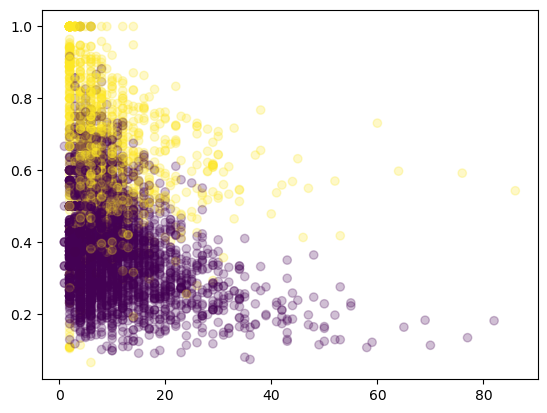

In [60]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
filterd_df = df[(df['failureType'] == 'Scratch') | (df['failureType'] == 'Loc')]
# filterd_df = df[(df['failureType'] == 'Scratch')]
# filterd_df = df[df['failureType'] == 'Loc']
filterd_df = filterd_df.reset_index()
y_train = le.fit_transform(np.array(filterd_df['failureType']))
x = filterd_df['thinning_counter_len']
y = filterd_df['thinning_rate']
plt.scatter(x, y, c = y_train, alpha=0.25)